In [1]:
import os
import os.path as osp
import glob
from PIL import Image
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms

train_dataset作成

In [26]:
CLASSES = ["bird", "cat", "deer", "dog", "frog", "horse"]
class Dataset(data.Dataset):
    def __init__(self, file_paths_list, transform, phase):
        self.file_paths_lsit = file_paths_list
        self.transform = transform
        self.train = True if phase=="train" else False
        
    def __len__(self):
        return len(self.file_paths_lsit)
    
    def __getitem__(self, index):
        # 読み込み
        path = self.file_paths_lsit[index]
        img = Image.open(path) # [高さ][幅][色RGB]
        
        # 前処理
        img_transformed = self.transform(img)
        
        # ラベル
        label = path.split("/")[4]
        label = CLASSES.index(label)
        
#         return img_transformed, label
        return path, img_transformed, label

In [27]:
# ファイルのpathリスト作成
train_dataset_paths = "./dataset/cifar/train/*/*"
test_dataset_paths = "./dataset/cifar/test/*/*"

train_dataset_paths_list = [_ for _ in glob.glob(train_dataset_paths)]
test_dataset_paths_list = [_ for _ in glob.glob(test_dataset_paths)]

In [28]:
print("len(train_dataset_paths_list):", len(train_dataset_paths_list)) # 6クラス * 5000枚/クラス = 30000枚
print("len(test_dataset_paths_list):", len(test_dataset_paths_list))

len(train_dataset_paths_list): 30000
len(test_dataset_paths_list): 4000


In [29]:
# 前処理インスタンスの定義
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [30]:
# train_datasetインスタンスの宣言
train_dataset = Dataset(train_dataset_paths_list, data_transforms, "train")

In [31]:
# データのラベルを格納したリスト
train_labels = np.array([train_dataset[index][2] for index in range(len(train_dataset))])

# ネットワーク定義

In [12]:
class EmbeddingNet(nn.Module):
    """ Basic Embedding Network
    """
    def __init__(self, fc_input_size=64*6*6):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=0),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2),
                                    nn.Conv2d(32, 64, 3),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2),
                                    )
        self.fc = nn.Sequential(nn.Linear(fc_input_size, 256),
                                nn.ReLU(),
                                nn.Linear(256, 64),
#                                 nn.Linear(64, 2),
                                )
    
    def forward(self, x):
        """ convnet -> flatten -> fc 
            input: torch.Size([batch_size, 3, 64, 64])
            output: torch.Size([batch_size, 64])
        """
        x = self.convnet(x)
        batch_size = x.size(0)
        x = x.view(batch_size, -1) # flatten
        x = self.fc(x)
        return x


class EmbeddingNetL2(EmbeddingNet):
    """ output l2 norm
    """
    def __init__(self):
        super(EmbeddingNetL2, self).__init__()

    def forward(slef, x):
        x = super(EmbeddingNetL2, self).forward(x)
        x /= x.pow(2).sum(1, keepdim=True).sqrt()
        return x

In [55]:
class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNet, self).__init__()
        self.embedding_net = embedding_net
    
    def forward(self, x1, x2):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        return output1, output2
    
    def get_embedding(self, x):
        return self.embedding_net(x)

# Online処理の定義

In [14]:
from itertools import combinations
def pdist(vectors):
    distance_matrix = -2 * vectors.mm(torch.t(vectors)) + vectors.pow(2).sum(dim=1).view(1, -1) + vectors.pow(2).sum(
        dim=1).view(-1, 1)
    return distance_matrix


class PairSelector:
    """
    Implementation should return indices of positive pairs and negative pairs that will be passed to compute
    Contrastive Loss
    return positive_pairs, negative_pairs
    """

    def __init__(self):
        pass

    def get_pairs(self, embeddings, labels):
        raise NotImplementedError


class AllPositivePairSelector(PairSelector):
    """
    Discards embeddings and generates all possible pairs given labels.
    If balance is True, negative pairs are a random sample to match the number of positive samples
    """
    def __init__(self, balance=True):
        super(AllPositivePairSelector, self).__init__()
        self.balance = balance

    def get_pairs(self, embeddings, labels):
        labels = labels.cpu().data.numpy()
        all_pairs = np.array(list(combinations(range(len(labels)), 2)))
        all_pairs = torch.LongTensor(all_pairs)
        positive_pairs = all_pairs[(labels[all_pairs[:, 0]] == labels[all_pairs[:, 1]]).nonzero()]
        negative_pairs = all_pairs[(labels[all_pairs[:, 0]] != labels[all_pairs[:, 1]]).nonzero()]
        if self.balance:
            negative_pairs = negative_pairs[torch.randperm(len(negative_pairs))[:len(positive_pairs)]]

        return positive_pairs, negative_pairs


class HardNegativePairSelector(PairSelector):
    """
    Creates all possible positive pairs. For negative pairs, pairs with smallest distance are taken into consideration,
    matching the number of positive pairs.
    """

    def __init__(self, cpu=True):
        super(HardNegativePairSelector, self).__init__()
        self.cpu = cpu

    def get_pairs(self, embeddings, labels):
        if self.cpu:
            embeddings = embeddings.cpu()
        distance_matrix = pdist(embeddings)

        labels = labels.cpu().data.numpy()
        all_pairs = np.array(list(combinations(range(len(labels)), 2)))
        all_pairs = torch.LongTensor(all_pairs)
        positive_pairs = all_pairs[(labels[all_pairs[:, 0]] == labels[all_pairs[:, 1]]).nonzero()]
        negative_pairs = all_pairs[(labels[all_pairs[:, 0]] != labels[all_pairs[:, 1]]).nonzero()]

        negative_distances = distance_matrix[negative_pairs[:, 0], negative_pairs[:, 1]]
        negative_distances = negative_distances.cpu().data.numpy()
        top_negatives = np.argpartition(negative_distances, len(positive_pairs))[:len(positive_pairs)]
        top_negative_pairs = negative_pairs[torch.LongTensor(top_negatives)]

        return positive_pairs, top_negative_pairs

# Loss関数の定義

In [15]:
class OnlineContrastiveLoss(nn.Module):
    """
    Online Contrastive loss
    Takes a batch of embeddings and corresponding labels.
    Pairs are generated using pair_selector object that take embeddings and targets and return indices of positive
    and negative pairs
    """

    def __init__(self, margin, pair_selector):
        super(OnlineContrastiveLoss, self).__init__()
        self.margin = margin
        self.pair_selector = pair_selector

    def forward(self, embeddings, target):
        positive_pairs, negative_pairs = self.pair_selector.get_pairs(embeddings, target)
        if embeddings.is_cuda:
            positive_pairs = positive_pairs.cuda()
            negative_pairs = negative_pairs.cuda()
        positive_loss = (embeddings[positive_pairs[:, 0]] - embeddings[positive_pairs[:, 1]]).pow(2).sum(1)
        negative_loss = F.relu(self.margin - (embeddings[negative_pairs[:, 0]] - embeddings[negative_pairs[:, 1]]).pow(2).sum(1).sqrt()).pow(2)
        loss = torch.cat([positive_loss, negative_loss], dim=0)
        return loss.mean()

# 学習の設定

In [9]:
from torch.utils.data import BatchSampler
        
class BalancedBatchSampler(BatchSampler):
    """ バッチの中でクラスが均等になるようにバッチ生成を行うサンプラー
    """
    def __init__(self, labels, n_classes, n_samples):
        """ labels: データのラベルリスト
            n_classes: データのクラスリスト
            n_samples: バッチに含まれる1クラスあたりのサンプル数
        """
        self.labels = labels
        self.labels_set = list(set(self.labels))
        self.label_to_indices = {label: np.where(self.labels == label)[0] for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][self.used_label_indices_count[class_]:self.used_label_indices_count[class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

In [66]:
# BatchSamplerの定義
train_batch_sampler = BalancedBatchSampler(train_labels, n_classes=len(CLASSES), n_samples=200)

In [67]:
# ローダの定義
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, num_workers=1)

In [82]:
# 学習の設定
margin = 40
embedding_net = EmbeddingNet()
model = embedding_net.to("cuda")
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 50
log_interval = 50

In [83]:
import time

# 時間計測開始
time_sta = time.perf_counter()

# fit 関数をそのまま書く
start_epoch = 0
losses = []
total_loss = 0

# train
for epoch in range(start_epoch, n_epochs):
    scheduler.step()
    model.train()
    losses = []
    total_loss = 0
    for batch_idx, (paths, datas, labels) in enumerate(online_train_loader):
        datas = datas.cuda()
        optimizer.zero_grad()
        outputs = model(datas) # data = ([(x11, x12), (x21, x22), ....])
        loss_outputs = loss_fn(outputs, labels)
        loss = loss_outputs
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    time_end = time.perf_counter()
    # 経過時間（秒）
    tim = time_end- time_sta
    print("epoch:", epoch, "loss:", loss.item(), "time:", tim)

/home/gesogeso/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


epoch: 0 loss: 535.27587890625 time: 10.41577620699536
epoch: 1 loss: 505.4479064941406 time: 20.608726545004174
epoch: 2 loss: 482.969970703125 time: 30.72932442399906
epoch: 3 loss: 467.60015869140625 time: 40.95334135100711
epoch: 4 loss: 458.3658447265625 time: 51.640121226984775
epoch: 5 loss: 455.9319763183594 time: 61.89363511398551
epoch: 6 loss: 451.14825439453125 time: 72.13621339199017
epoch: 7 loss: 450.1485900878906 time: 82.3701882000023
epoch: 8 loss: 447.26422119140625 time: 92.62069133098703
epoch: 9 loss: 446.2303466796875 time: 102.8172220189881
epoch: 10 loss: 447.86199951171875 time: 113.01552740199259
epoch: 11 loss: 447.7190856933594 time: 123.24188861399307
epoch: 12 loss: 444.702392578125 time: 133.47690208099084
epoch: 13 loss: 445.7783203125 time: 143.70618173800176
epoch: 14 loss: 444.51873779296875 time: 153.9605650769954
epoch: 15 loss: 442.9697570800781 time: 164.19405440599076
epoch: 16 loss: 444.3051452636719 time: 174.45501765000517
epoch: 17 loss: 444

# Plot Embedding

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline
CLASSES = ["bird", "cat", "deer", "dog", "frog", "horse"]
classes_num = [i for i in range(len(CLASSES))]
colors = ["red", "blue", "pink", "orange", "yellow", "green"]
def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(len(CLASSES)):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.xlim(ylim[0], ylim[1])
    plt.legend(CLASSES)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 64))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for paths, images, targets in dataloader:
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = targets.numpy()
            k += len(images)
    return embeddings, labels

In [84]:
batch_size = 128
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [85]:
siamese_model = SiameseNet(embedding_net.cpu())
train_embeddings, train_labels = extract_embeddings(train_loader, siamese_model)

In [86]:
import umap
um = umap.UMAP()
um.fit(train_embeddings)
train_embeddings_umap = um.transform(train_embeddings)

/home/gesogeso/.local/lib/python3.6/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../.local/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


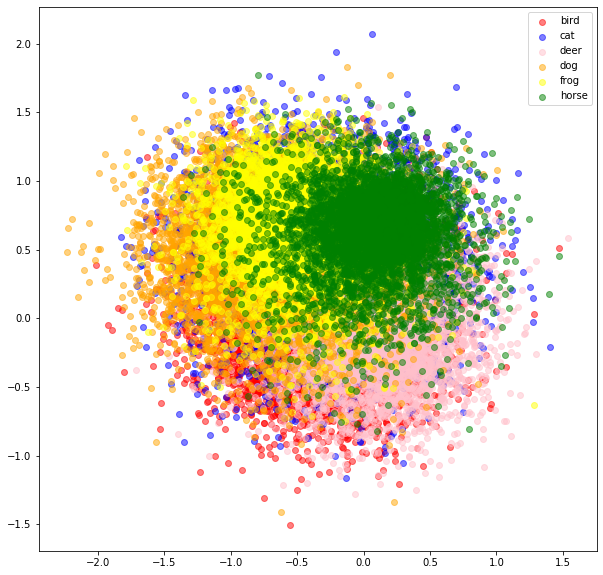

In [60]:
# margin:50 epoch:20
plot_embeddings(train_embeddings, train_labels)

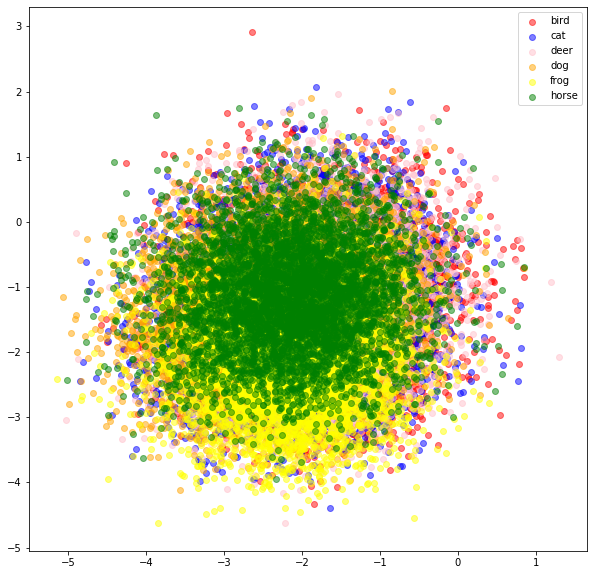

In [80]:
# margin: 20 epoch: 50 batch_size: 120
plot_embeddings(train_embeddings, train_labels)

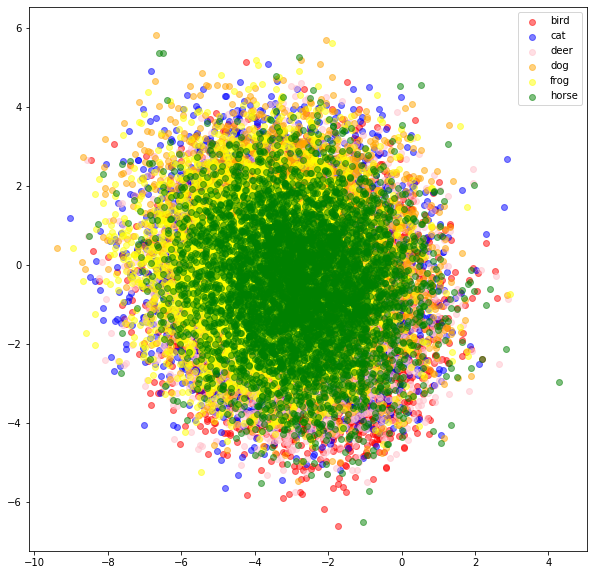

In [87]:
# margin: 40 epoch: 50 batch_size: 120
plot_embeddings(train_embeddings, train_labels)

In [61]:
# margin:50 epoch:20
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(train_embeddings)

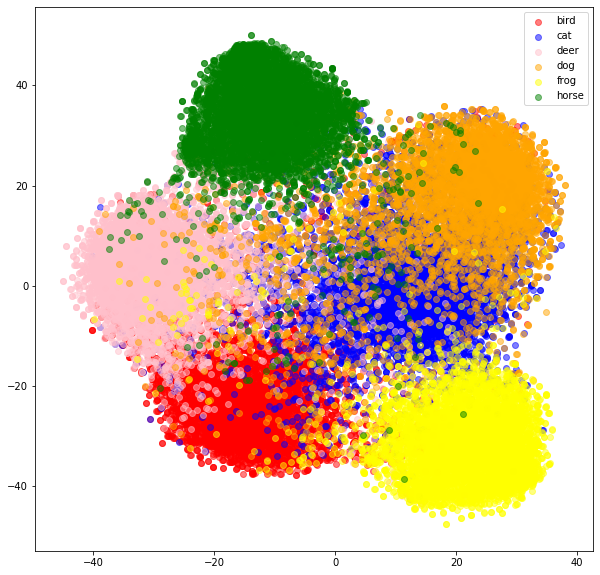

In [62]:
plot_embeddings(X_embedded, train_labels)

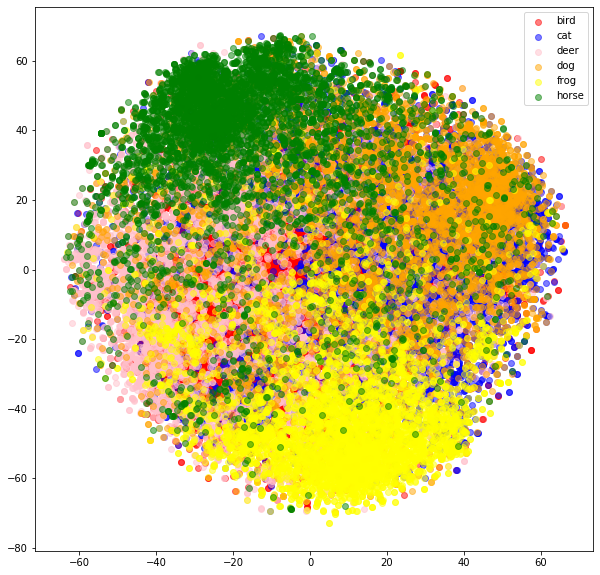

In [81]:
# margin: 20 epoch: 50 batch_size: 120
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(train_embeddings)
plot_embeddings(X_embedded, train_labels)

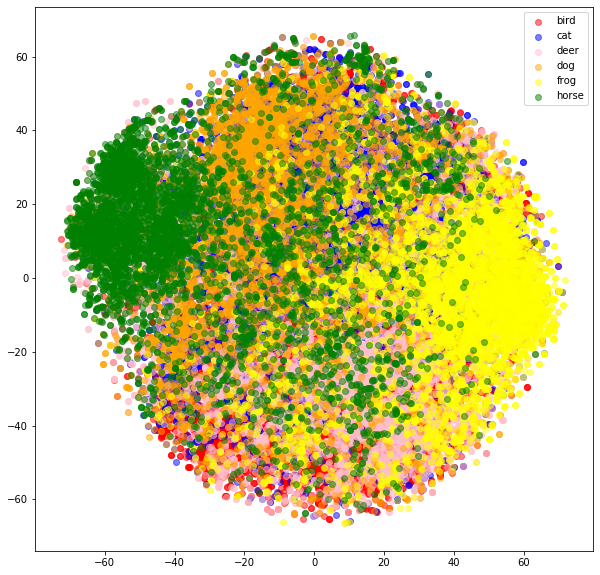

In [88]:
# margin:40 epoch:50
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(train_embeddings)
plot_embeddings(X_embedded, train_labels)